In [2]:
import heapq

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

In [3]:

class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0  # Cost from start to node
        self.h = 0  # Heuristic, estimated cost from node to end
        self.f = 0  # Total cost

    def __lt__(self, other):
        return self.f < other.f

def a_star(grid, start, end):
    # Create start and end node
    start_node = Node(start)
    end_node = Node(end)

    # Initialize open and closed list
    open_list = []
    closed_list = set()

    # Add the start node
    heapq.heappush(open_list, start_node)

    # Loop until the end
    while open_list:
        current_node = heapq.heappop(open_list)
        closed_list.add(current_node.position)

        # Check if we reached the end
        if current_node.position == end_node.position:
            path = []
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Adjacent squares
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])
            
            # Make sure within range and not in water
            if node_position[0] > (len(grid) - 1) or node_position[0] < 0 or node_position[1] > (len(grid[len(grid)-1]) - 1) or node_position[1] < 0:
                continue
            if grid[node_position[0]][node_position[1]] != 0:
                continue
            
            # Create new node and append
            new_node = Node(node_position, current_node)
            children.append(new_node)

        # Loop through children
        for child in children:
            if child.position in closed_list:
                continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            heapq.heappush(open_list, child)

    return None  # Path not found

In [4]:

# Example grid (0 = water, 1 = obstacle)
grid = [
    [0, 0, 0, 0, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 0, 1, 0],
    [1, 0, 0, 1, 0],
    [1, 1, 0, 0, 0]
]

start = (0, 0)  # Starting position
end = (4, 4)   # Ending position


# Assuming the rest of the A* code is defined here...

path = a_star(grid, start, end)
print(path)

[(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)]


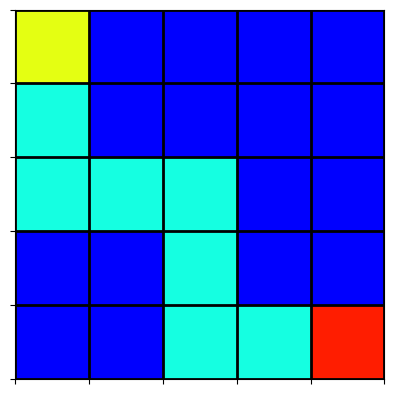

In [6]:

# Convert path to a grid for visualization
path_grid = np.zeros_like(grid)
for point in path:
    path_grid[point[0]][point[1]] = 2  # 2 will represent the path

# Update the path_grid with obstacles and start/end points
for i in range(len(grid)):
    for j in range(len(grid[i])):
        if grid[i][j] == 1:
            path_grid[i][j] = 1  # 1 represents obstacles
path_grid[start[0]][start[1]] = 3  # 3 represents the start point
path_grid[end[0]][end[1]] = 4      # 4 represents the end point

# Set up the color map (water: blue, obstacle: black, path: yellow, start: green, end: red)
cmap = plt.cm.jet
cmap.set_under('blue')  # Water
cmap.set_over('red')    # End
norm = plt.Normalize(0.5, 4.5)

# Create the plot
fig, ax = plt.subplots()
ax.imshow(path_grid, cmap=cmap, norm=norm)

# Add gridlines and set ticks
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, len(grid[0]), 1))
ax.set_yticks(np.arange(-.5, len(grid), 1))

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

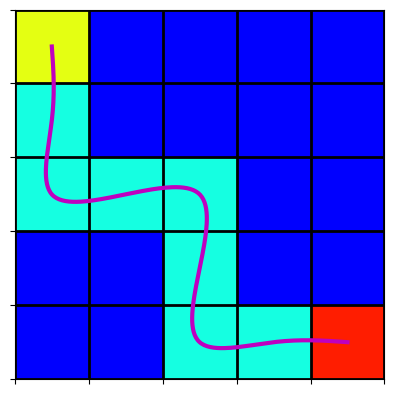

In [11]:


# Assuming the rest of the A* code and path calculation is above...

# Convert the A* path into a series of points
x = [point[1] for point in path]  # Note: swapping x and y because of grid representation
y = [point[0] for point in path]

# Generate parameter t based on path indices
t = np.arange(len(x))

# Create a cubic spline interpolation of the path
cs_x = CubicSpline(t, x, bc_type='natural')
cs_y = CubicSpline(t, y, bc_type='natural')

# Generate fine-grained parameter values for a smooth curve
t_fine = np.linspace(0, t[-1], 300)

# Evaluate the spline at the fine-grained parameter values
smooth_x = cs_x(t_fine)
smooth_y = cs_y(t_fine)

# Now, let's add this to the visualization code from before
# Assuming path_grid and other plotting code is already defined...

fig, ax = plt.subplots()
ax.imshow(path_grid, cmap=cmap, norm=norm)

# Plot the smooth path
ax.plot(smooth_x, smooth_y, 'm-', linewidth=3)  # 'm-' sets the color to magenta

# Add gridlines and set ticks (same as before)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, len(grid[0]), 1))
ax.set_yticks(np.arange(-.5, len(grid), 1))

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()


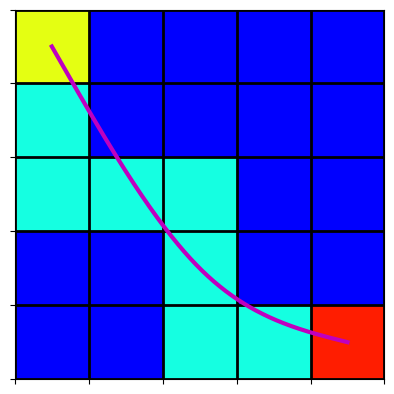

In [12]:

# Reduce the number of points by selecting key points
key_indices = [0]  # Always include the first point
distance_threshold = 3  # Define how far apart points should be to be considered key points

for i in range(1, len(path) - 1):
    # Check if this point is far enough from the last key point
    if abs(path[i][0] - path[key_indices[-1]][0]) >= distance_threshold or \
       abs(path[i][1] - path[key_indices[-1]][1]) >= distance_threshold:
        key_indices.append(i)

key_indices.append(len(path) - 1)  # Always include the last point

# Now create a new path with these key points
key_path = [path[i] for i in key_indices]

# Extract x and y coordinates as before, but using the key path
x = [point[1] for point in key_path]
y = [point[0] for point in key_path]
t = np.arange(len(x))

# Recalculate the cubic splines with these key points
cs_x = CubicSpline(t, x, bc_type='natural')
cs_y = CubicSpline(t, y, bc_type='natural')
t_fine = np.linspace(0, t[-1], 300)
smooth_x = cs_x(t_fine)
smooth_y = cs_y(t_fine)

# Now, let's add this to the visualization code from before
# Assuming path_grid and other plotting code is already defined...

fig, ax = plt.subplots()
ax.imshow(path_grid, cmap=cmap, norm=norm)

# Plot the smooth path
ax.plot(smooth_x, smooth_y, 'm-', linewidth=3)  # 'm-' sets the color to magenta

# Add gridlines and set ticks (same as before)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-.5, len(grid[0]), 1))
ax.set_yticks(np.arange(-.5, len(grid), 1))

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()


In [1]:
import math

def longitude_distance(lat, lon1, lon2):
    # Radius of the Earth in meters
    R = 6371000
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon1_rad = math.radians(lon1)
    lon2_rad = math.radians(lon2)
    
    # Difference in longitude
    delta_lon = lon2_rad - lon1_rad
    
    # Distance calculation
    distance = R * abs(delta_lon) * math.cos(lat_rad)
    return distance

# Example usage
latitude = 58  # Example latitude (New York City)
longitude1 = 11.25
longitude2 = 11.25+0.125

# so 7365 meters gives 0,00001697216565 per meter
dist = longitude_distance(latitude, longitude1, longitude2)
print(f"Distance between longitudes: {dist:.2f} meters")


Distance between longitudes: 7365.54 meters


Grid size: (589, 589)


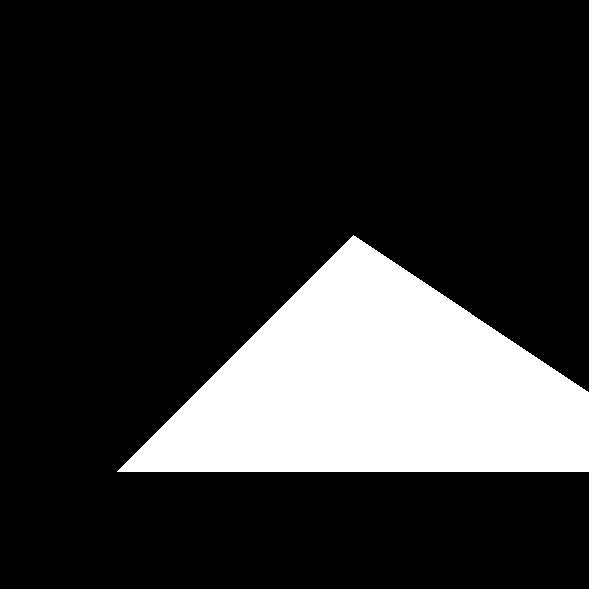

: 

In [26]:
import numpy as np
import cv2
from IPython.display import display, Image

# Constants for the geographic to grid conversion
DEGREES_PER_CELL = 0.00008486082824  # Approximate degrees per 5 meters
#DEGREES_PER_CELL = 0.00008486082824*10  # Approximate degrees per 5 meters
EARTH_RADIUS = 6371000  # Radius of Earth in meters

# Define your geographic bounds
lon_min, lon_max = 11, 11.05  # Example longitude range
lat_min, lat_max = 50, 50.05     # Example latitude range

def degrees_to_cells(degrees):
    return int(degrees / DEGREES_PER_CELL)

# Calculate grid dimensions
lon_cells = degrees_to_cells(lon_max - lon_min)
lat_cells = degrees_to_cells(lat_max - lat_min)

# Create the grid matrix initialized to 0
grid = np.zeros((lat_cells, lon_cells), dtype=np.uint8)

# Example list of polygons (each polygon is a list of (lon, lat) tuples)
polygons = [
    [(11.01, 50.01), (11.03, 50.03), (11.06, 50.01), (11.06, 50.01)],  # Polygon 1
    #[(-123.11, 49.26), (-123.12, 49.26), (-123.12, 49.25), (-123.11, 49.25)]   # Polygon 2
]

def mark_polygon_on_grid(polygons):
    for polygon in polygons:
        # Convert polygon coordinates to grid indices
        pts = np.array([
            (degrees_to_cells(lon - lon_min), degrees_to_cells(lat_max - lat)) 
            for lon, lat in polygon
        ], np.int32)
        #print(pts)
        # Reshape points for fillPoly
        pts = pts.reshape((-1, 1, 2))
        
        # Fill the polygon area with 1
        cv2.fillPoly(grid, [pts], 1)

# Mark polygons on the grid
mark_polygon_on_grid(polygons)


print("Grid size:", grid.shape)
# Encode image as a JPEG 
_, buffer = cv2.imencode('.jpg', grid*255)

# Convert to byte array
image_bytes = buffer.tobytes()

# Display the image
display(Image(data=image_bytes))
# # Optionally, display the grid as an image
# cv2.imshow('Grid', grid * 255)  # Scale by 255 to see the polygons clearly in the image display
# cv2.waitKey(0)
# cv2.destroyAllWindows()
